In [5]:
# --- global imports --------------------------------------------------
import numpy as np, pandas as pd, json, lightgbm as lgb, xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score
import openml, sklearn
from src import DataBinner
from sklearn.preprocessing import LabelEncoder

benchmark_suite = openml.study.get_suite(337) #337 for classification
benchmark_id = 0
task_id = benchmark_suite.tasks[benchmark_id]

task = openml.tasks.get_task(task_id)
dataset = task.get_dataset()

X, y, _, _ = dataset.get_data(target=dataset.default_target_attribute,
                    dataset_format="dataframe")
X = X.iloc[:, [0]]
y = LabelEncoder().fit_transform(y)  # Encode labels for classification

# --- simple deterministic split -------------------------------------
rng = np.random.default_rng(1)
idx = rng.permutation(len(X))
tr, te = idx[:int(.8*len(X))], idx[int(.8*len(X)):]
Xtr, Xte, ytr, yte = X.iloc[tr], X.iloc[te], y[tr], y[te]

# --- our three binners ----------------------------------------------
b_q  = DataBinner("quantile", 255, random_state=0).fit(Xtr)
b_k  = DataBinner("kmeans",  255, random_state=0).fit(Xtr)
b_ls = DataBinner("linspace", 255, random_state=0).fit(Xtr)

In [3]:
# --- dump bin counts for inspection ---------------------------------
for name,b in [("Q",b_q),("K",b_k),("L",b_ls)]:
    bins = [len(c)+1 for c in b._models]
    print(name, "bins/feat  mean=", np.mean(bins), "min=", min(bins))

Q bins/feat  mean= 255.0 min= 255
K bins/feat  mean= 255.0 min= 255
L bins/feat  mean= 255.0 min= 255


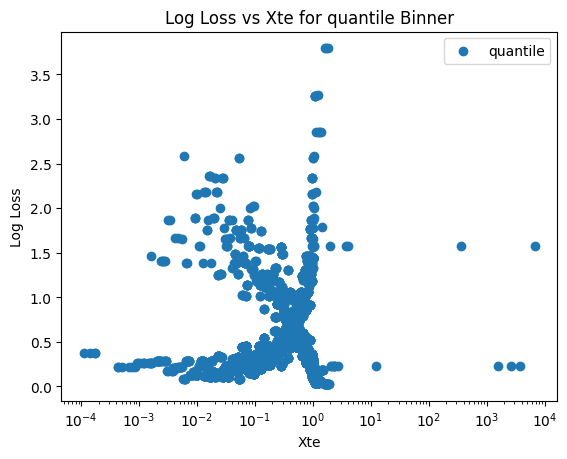

Acc  quantile train/test error:  (0.7220103208436168, 0.7164223751121747, 0.5795937120556072)


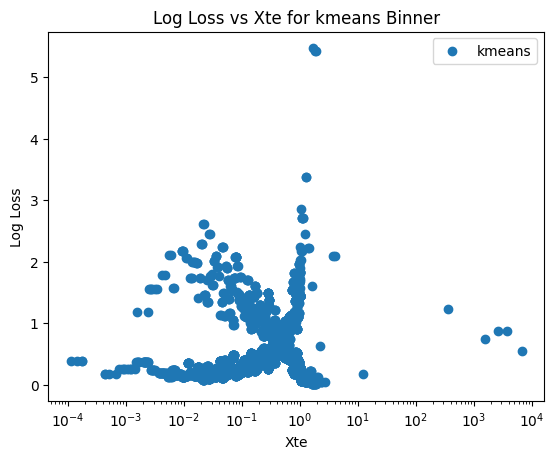

Acc  k‑means train/test error:   (0.7221598982873383, 0.7125336524080168, 0.584462845963596)


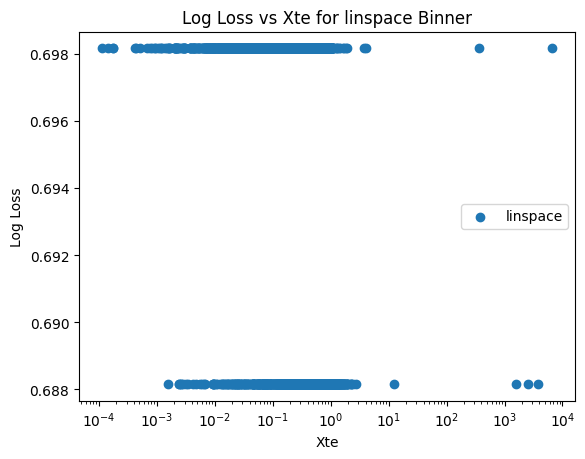

Acc  linspace train/test error:  (0.5025054221823348, 0.4899790607239007, 0.6932601625729182)


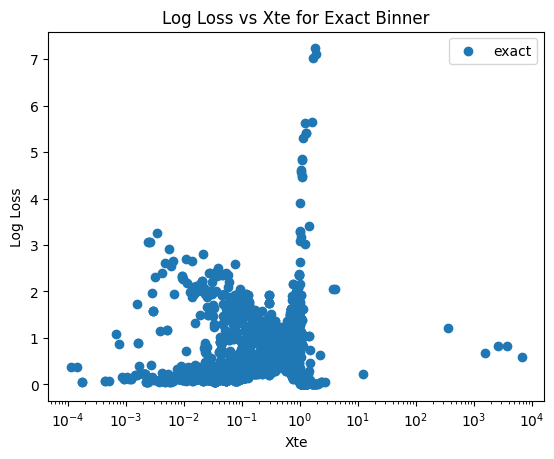

Acc exact method (0.778774960735921, 0.6954830990128626)


In [13]:
import matplotlib.pyplot as plt
# --- fixed‑param LightGBM -------------------------------------------
params = dict(
    n_estimators=300, learning_rate=0.05, num_leaves=63,
    random_state=0, verbosity=-1, min_data_in_bin=1, feature_pre_filter=False
)

def mse(binner):
    method = binner.method
    mdl = lgb.LGBMClassifier(**params, max_bin=255)
    mdl.fit(binner.transform(Xtr), ytr)
    
    prob_preds = mdl.predict_proba(binner.transform(Xte))[:, 1]
    log_loss = -1 * (yte * np.log(prob_preds) + (1 - yte) * np.log(1 - prob_preds))
    
    #Printing loss as a function of xte:
    plt.scatter(Xte, log_loss, label=method)
    plt.xlabel("Xte")
    plt.ylabel("Log Loss")
    plt.xscale('log')
    plt.title(f"Log Loss vs Xte for {method} Binner")
    plt.legend()
    plt.show()
    
    return accuracy_score(ytr, mdl.predict(binner.transform(Xtr))), accuracy_score(yte, mdl.predict(binner.transform(Xte))), np.mean(log_loss)

print("Acc  quantile train/test error: ", mse(b_q))
print("Acc  k‑means train/test error:  ", mse(b_k))
print("Acc  linspace train/test error: ", mse(b_ls))

#MSE for no binner
mdl = lgb.LGBMClassifier(**params, max_bin = len(Xtr))
mdl.fit(Xtr, ytr)
prob_preds = mdl.predict_proba(Xte)[:, 1]
log_loss = -1 * (yte * np.log(prob_preds) + (1 - yte) * np.log(1 - prob_preds))

#Printing loss as a function of xte:
plt.scatter(Xte, log_loss, label='exact')
plt.xlabel("Xte")
plt.ylabel("Log Loss")
plt.xscale('log')
plt.title(f"Log Loss vs Xte for Exact Binner")
plt.legend()
plt.show()

print("Acc exact method", (accuracy_score(mdl.predict(Xtr), ytr), accuracy_score(mdl.predict(Xte), yte)))

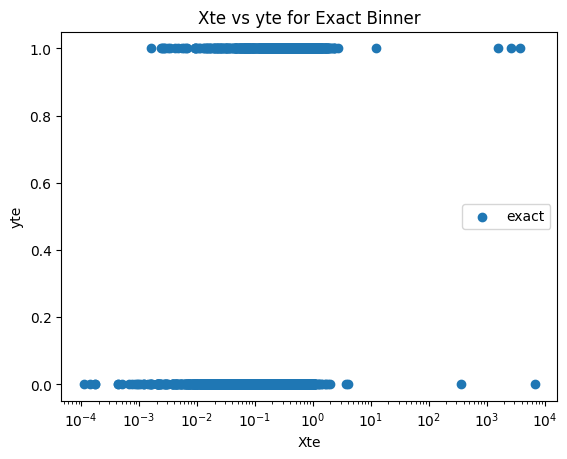

In [12]:
#Comparing x vs y
plt.scatter(Xte, yte, label='exact')
plt.xlabel("Xte")
plt.ylabel("yte")
plt.xscale('log')
plt.title(f"Xte vs yte for Exact Binner")
plt.legend()